In [19]:
import csv
import pandas as pd
import os
from matplotlib import pyplot as plt
import time
from textwrap import wrap
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

In [20]:
def read_crime_data():
    
    file = os.path.join('Resources','Crimes_2001_to_present.csv')
    crime_df = pd.read_csv(file)
    return crime_df

def get_crimes_count(df):

    # data clean up 
    start_time = time.time() 
    cols = ['ID', 'Case Number', 'Date', 'Primary Type', 'Ward']
    df = df.loc[:, cols]
    df = df[df['Primary Type'] != 'NON - CRIMINAL' ]
    df = df[df['Primary Type'] != 'NON-CRIMINAL' ] 
    df = df[df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)' ]
    # print('Total=',df.ID.count())     #6900557
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # get the crime count based on TYPE and Date stamp
    groupedby = df.groupby(['Primary Type','Ward', 'Date'])
    crime_counts = groupedby["ID"].count()
    elapsed_time = time.time() - start_time
    print("elapsed time=", elapsed_time)   # 15 minutes
    crime_count_df = pd.DataFrame(crime_counts).reset_index()
    crime_count_df.columns = [ 'Offense Type', 'Ward', 'Date', 'Crime Count' ]
    return crime_count_df

In [21]:
def read_weather_data():
    # get the free weather historial csv data-set from
    # https://www.meteoblue.com/products/historyplus/download/basel_switzerland_2661604
    file = os.path.join('Resources','weather_2001_present.csv')
    weather_df = pd.read_csv(file)

    # data clean up 
    weather_df = weather_df.dropna(axis=1, how='any')

    # Create Date from Year, Month, Day
    weather_df.reset_index()
    
    # Reformat Date from Year, Month, Day
    weather_df['Date'] = pd.to_datetime(weather_df[['Month', 'Day', 'Year']])
    weather_df['Year'] = weather_df['Date'].dt.to_period('Y').apply(str)
    weather_df['Month'] = weather_df['Date'].dt.to_period('M').apply(str)
    weather_df['Date'] = weather_df['Date'].dt.date

    # clean up 
    weather_df = weather_df.drop(['Day'], axis = 1) 
    weather_df = weather_df.dropna(axis=1, how='any')

    # Reorder the Date to the first column and select the column interested
    cols = list(weather_df)
    cols.insert(0, cols.pop(cols.index('Date')))
    cols = cols[0:3] + cols[4:7] +  cols[8:9] + cols[12:13] + cols[18:19] + cols[21:22]
    # finalize the weather data frame
    weather_df = weather_df.loc[:, cols]

    # rename column title - give a shorted name
    #   Temperature daily max [2 m above gnd]
    weather_df.rename(columns={ 'Relative Humidity daily mean [2 m above gnd]':'Humidity daily mean', \
                           'Mean Sea Level Pressure daily mean [MSL]':'Mean Sea Level Pressure daily mean', \
                           'Total Precipitation (low resolution) daily sum [sfc]' : 'Precipitation daily sum', \
                           'Total Cloud Cover daily mean [sfc]' : 'Total Cloud Cover daily mean', \
                           'Sunshine Duration daily sum [sfc]' : 'Sunshine Duration daily sum', \
                           'Wind Speed daily mean [900 mb]' : 'Wind Speed daily mean', \
                           'Temperature daily max [2 m above gnd]':'Temperature daily max (F)'
                          }, inplace=True)
    print('columns=', list(weather_df))
    return weather_df

In [22]:
def get_crime_weather_merged(crime_df, weather_df):
    # merge weather data and crime date on Date as Key
    crimes_weather_df = pd.merge(crime_df, weather_df, on="Date", how="left")
    cols = list(crimes_weather_df)
    cols = cols[2:3] + cols[4:6] + cols[1:2] + cols[0:1] + cols[3:4] + cols[6:]
    crimes_weather_df = crimes_weather_df.loc[:, cols]
    crimes_weather_df = crimes_weather_df.dropna(axis=0, how='any')

    # change all values to integer
    for col in cols[6:]:
        crimes_weather_df[col] = crimes_weather_df[col].round(0).astype(int)
    
    return crimes_weather_df

In [23]:
def validate_year(years=[2001, 2019]):
    if len(years) < 2 or years[0] > years[1]:
        years = [2001, 2019]
    elif years[0] < 2001:
        years[0] = 2001
    elif years[1] > 2019:
        years[1] = 2019 
    return years

In [24]:
def plot_crime_weather( df, plot_type = 'scatter', offense_types = ['ROBBERY', 'ASSAULT'], \
                               meas_type = 'Total Cloud Cover daily mean', years = [2001, 2019], from_widget = False ):
    
    years = validate_year(years) 
    # Set up plot title
    measurement_dur_str = '  from ' + str(years[0]) + "-01 to 2019-05" 
    title = 'Chicago Crime Count Under ' + meas_type + measurement_dur_str 
    
    # create data frame only for the type of crimes that are concerned
    cw_type_df = pd.DataFrame(df.loc[(df['Offense Type'] == offense_types[0]) & (df['Year'].astype(int) >= years[0]) & \
                    (df['Year'].astype(int) <= years[1]), \
                    [meas_type, "Crime Count" ]].groupby(meas_type)['Crime Count'].sum()).reset_index()
    cw_type_df.rename(columns={ 'Crime Count':offense_types[0] }, inplace=True)
    for offense in offense_types[1:]:
        crime_one_type_df = pd.DataFrame(df.loc[(df['Offense Type'] == offense), \
                    [meas_type, "Crime Count" ]].groupby(meas_type)['Crime Count'].sum()).reset_index()
        crime_one_type_df.rename(columns={ 'Crime Count': offense }, inplace=True)
        cw_type_df = pd.merge(cw_type_df, crime_one_type_df, on=meas_type, how="outer")
        
    cw_type_df = cw_type_df.fillna(value=0).astype(int)
    cw_type_df.set_index(meas_type, inplace=True)
    
    # Plot 
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = ax.set_title("\n".join(wrap(title, 40)))
    labels = [ '\n'.join(wrap(i, 20)) for i in cw_type_df.columns ]

    ax.legend(labels, bbox_to_anchor=(1, 0.5))

    if from_widget == True:
        plt.subplots_adjust(left=0, right = 1.2, bottom  = 0.1,  top=1.8)
    else:
        plt.subplots_adjust(left=0, right = 2, bottom  = 0.1,  top= 3.0)
    x = cw_type_df.index.values
    
    if plot_type == 'line':
        for i in range(cw_type_df.shape[1]):
             plt.plot(x,cw_type_df.iloc[:, i],label=labels[i])
    elif plot_type == 'scatter':
        for crime, label in zip(cw_type_df.columns.values, labels):
            ax.scatter(x, cw_type_df[crime], alpha=0.8, \
                        edgecolors='black', s=20, label=label)
    else:
        print("Not supported")
        return
        
    plt.xlabel(meas_type, fontsize=12)
    plt.ylabel("Crime count", fontsize=12)
    plt.legend(loc=2)
    plt.tight_layout()
    plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [25]:
def plot_crimes_wards(df, plot_type = 'bar', offense_types = ['ROBBERY', 'ARSON'], \
                             wards=[1, 50], years=[2001,2019], from_widget = False):
    
    years = validate_year(years) 
    
    colors = ['r','b', 'coral', 'g', 'y', 'k']
    title = 'Chicago Crime Count Per WARD\n' + ' from ' + str(years[0]) + "-01 to " + str(years[1]) + \
                                                           ('-05' if years[1] == 2019 else  '-12')
    
    df['Year'] = pd.to_datetime(df['Date']).dt.to_period('Y').apply(str).astype(int)
    cols = list(df.columns.values)
    df1 = pd.DataFrame(columns=cols)
    for i in offense_types:
        for j in wards:
            df2 = df.loc[ (df['Offense Type'] == i) & (df['Ward'].astype(int) == j) &  \
                          (df['Year'] >= years[0]) & (df['Year'] <= years[1]), :]
            df1 = df1.append(df2, ignore_index = True)        
    df1['Ward'] = df1['Ward'].astype(int)
    plt.tight_layout()
    
    ci = 0
    for offense_type in offense_types:
        
        grouped_data = df1.loc[ df1['Offense Type'] == offense_type, ['Ward', "Crime Count" ]].groupby('Ward')
        by_sum_df = pd.DataFrame(grouped_data['Crime Count'].sum())
        index_values = by_sum_df.index.values
        
        if (len(index_values) == 0):
            print("NO DATA for ", offense_type)
            continue
        plt.figure(figsize=(5*(len(index_values) // 10 + 1), 3*(len(index_values) // 25 + 1) ))
        
        plt.bar(range(len(index_values)), by_sum_df['Crime Count'], color=colors[ci], alpha=0.5, width=0.8, align="center")
        ci = (ci + 1 ) % len(colors)
          #  width=4)
        fsize = 14 + (6 * (len(index_values) // 26))
        plt.title(title, fontsize=fsize)
        plt.xlabel("Wards", fontsize=fsize)
        plt.ylabel(offense_type + " Crime Count", fontsize=fsize)
        plt.xticks(range(len(index_values)), index_values, fontsize=fsize )
        plt.yticks(fontsize=fsize)
        plt.xlim(-1,len(index_values))
    plt.show()

In [26]:
def plot_crime_counts(df, plot_type = 'line2', offense_types = ['ROBBERY', 'ARSON'], years = [ 2001, 2018 ]):
    
    years = validate_year(years) 
    
    colors = ['r','b', 'coral', 'g', 'y', 'k']
    per_month = 'Per Month'
    title = 'Chicago Crime Count Per Month Sum\n from ' + str(years[0]) + "-01 to " + str(years[1]) + \
                                                           ('-05' if years[1] == 2019 else  '-12')

    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    cols = list(df.columns.values)
    df1 = pd.DataFrame(columns=cols)

    for i in offense_types:
        df2 = df.loc[ (df['Offense Type'] == i)  &  \
                        (df['Year'] >= years[0]) & (df['Year'] <= years[1]), :]
        df1 = df1.append(df2, ignore_index = True)
        
    del df1['Ward']
    df1['Month'] = df1['Month'].astype(str).str.zfill(2)

    ci = 1
    for offense_type in offense_types:
        grouped_data = df1.loc[ df1['Offense Type'] == offense_type, ['Month', "Crime Count" ]].groupby('Month')
        by_sum_df = pd.DataFrame(grouped_data["Crime Count"].sum())
        index_values = by_sum_df.index.values
        
        if (len(index_values) == 0):
             print("NO DATA for ", offense_type)
             continue
            
        plt.figure(figsize=(5*(len(index_values) // 10 + 1), 3*(len(index_values) // 25 + 1) ))
    
        if plot_type == 'bar2':
            plt.bar(range(len(index_values)), by_sum_df['Crime Count'], color=colors[ci], alpha=0.5, width=0.8, align="center")
        elif plot_type == 'line2':
            plt.plot(index_values,by_sum_df['Crime Count'],  marker="o", color=colors[ci])
        else:
            print(" NOT SUPPORTED ........")    
        ci = (ci + 1 ) % len(colors)
        fsize = 14 + (6 * (len(index_values) // 26))
        plt.title(title, fontsize=fsize)
        plt.xlabel("Month", fontsize=fsize)
        plt.ylabel(offense_type + " Crime Count", fontsize=fsize)
        plt.xticks(range(len(index_values)), index_values, fontsize=fsize )
        plt.yticks(fontsize=fsize)
        plt.xlim(-1,len(index_values))
    plt.show()

    # Summary for all Crime Type
    crime_types = { i for i in df['Offense Type']}
    grouped_data = df.loc[(df['Year'] >= years[0]) & (df['Year'] <= years[1]), :].groupby('Offense Type')
    by_sum_df = pd.DataFrame(grouped_data['Crime Count'].sum())
    plt.figure(figsize=(16, 8 ))
    plt.title("Chicago Crime Counts Summary from " + str(years[0]) + "-01 to " + str(years[1]) + \
                                                           ('-05' if years[1] == 2019 else  '-12'))
    index_values = by_sum_df.index.values
    plt.xticks( [ i for i in range(len(index_values)) ], index_values, fontsize=14, rotation="vertical" )
    plt.xlabel("Crime Type", fontsize=fsize)
    plt.ylabel(offense_type + " Crime Count", fontsize=fsize)
    if (len(index_values) == 0):
        print("NO DATA")
    else:
        plt.bar(index_values, by_sum_df['Crime Count'], color=colors[0], alpha=0.5, width=0.8, align="center")
 
    plt.show


Start plotting ...
elapsed time= 825.4063832759857
columns= ['Date', 'Year', 'Month', 'Humidity daily mean', 'Mean Sea Level Pressure daily mean', 'Precipitation daily sum', 'Total Cloud Cover daily mean', 'Sunshine Duration daily sum', 'Wind Speed daily mean', 'Temperature daily max (F)']


<Figure size 432x288 with 0 Axes>

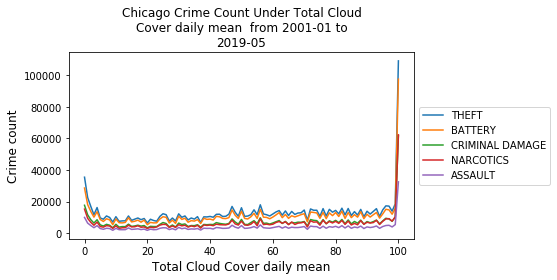

<Figure size 432x288 with 0 Axes>

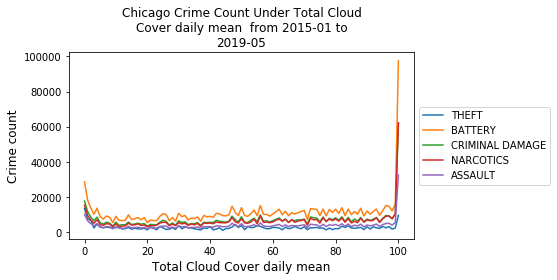

<Figure size 432x288 with 0 Axes>

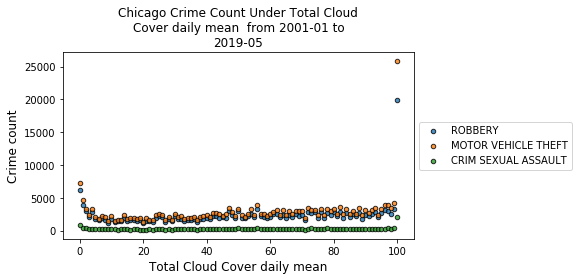

<Figure size 432x288 with 0 Axes>

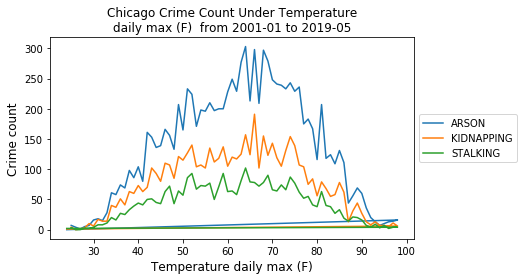

<Figure size 432x288 with 0 Axes>

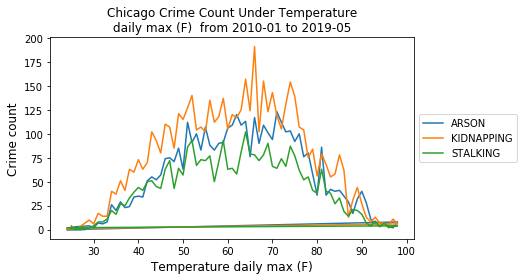

<Figure size 432x288 with 0 Axes>

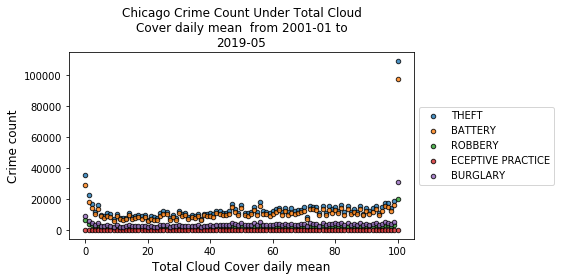

<Figure size 432x288 with 0 Axes>

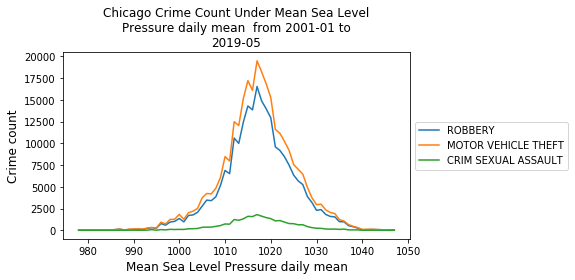

<Figure size 432x288 with 0 Axes>

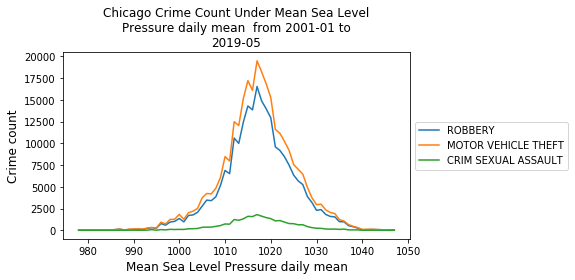

In [27]:
if __name__ == '__main__':
    print('Start plotting ...')
    crime_count_df = get_crimes_count(read_crime_data())
    weather_df = read_weather_data()
    crimes_weather_df = get_crime_weather_merged(crime_count_df, weather_df)
    
    plot_crimes_wards(df = crime_count_df, plot_type = 'bar', offense_types = ['ROBBERY', 'ARSON'], \
                             wards=[1, 25, 35, 50], years=[2010,2019], from_widget = False)
    plot_crimes_wards(df = crime_count_df, plot_type = 'bar', \
             offense_types = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT', 'OTHER OFFENSE'], \
             wards=[i for i in range(1,51)]  , years=[2001,2019], from_widget = False)
    
    plot_crime_counts(crime_count_df, plot_type = 'line2', offense_types = ['ROBBERY', 'ARSON'], years = [ 2001, 2018 ])
    plot_crime_counts(crime_count_df, plot_type =  'bar2', offense_types = ['ROBBERY', 'ARSON'], years = [ 2001, 2018 ])

    plot_crime_counts(crime_count_df, plot_type = 'line2', offense_types = ['CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'], \
                    years = [ 2001, 2018 ])
    
    plot_crime_weather(crimes_weather_df, plot_type = 'line', \
                  offense_types = [ 'THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT' ] )
    plot_crime_weather(crimes_weather_df, plot_type = 'line', \
                  offense_types = [ 'THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'], \
                  years = [2015,2019])
    plot_crime_weather(crimes_weather_df, offense_types = [ 'ROBBERY', 'MOTOR VEHICLE THEFT', 'CRIM SEXUAL ASSAULT' ] )
    plot_crime_weather(crimes_weather_df, plot_type='line', \
                   offense_types = [ 'ARSON', 'KIDNAPPING', 'STALKING'], \
                    meas_type = 'Temperature daily max (F)')
    plot_crime_weather(crimes_weather_df, plot_type='line', \
                   offense_types = [ 'ARSON', 'KIDNAPPING', 'STALKING'], \
                    meas_type = 'Temperature daily max (F)', years = [2010, 2019])
    plot_crime_weather(crimes_weather_df, offense_types = ['THEFT', 'BATTERY', 'ROBBERY', 'ECEPTIVE PRACTICE', 'BURGLARY'])
    plot_crime_weather(crimes_weather_df, plot_type='line',  \
                       offense_types = [ 'ROBBERY', 'MOTOR VEHICLE THEFT', 'CRIM SEXUAL ASSAULT' ] , \
                       meas_type = 'Mean Sea Level Pressure daily mean' )
    plot_crime_weather(crimes_weather_df, plot_type='line', \
                       offense_types = [ 'ROBBERY', 'MOTOR VEHICLE THEFT', 'CRIM SEXUAL ASSAULT' ] , \
                       meas_type = 'Mean Sea Level Pressure daily mean' )